In [1]:
import numpy as np
import tifffile
import os
import pandas as pd
import glob
import random
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [2]:
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(5)

In [3]:
def set_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:1')
    else:
        device = torch.device('cpu')
        
    print(device)

    return device


device = set_device()

cuda:1


In [6]:
def test_transform(img):
    x = np.zeros(img.shape,dtype=np.float32)
    for i in range(img.shape[0]):
        if img[i].min() >= 0:
            img[i]/=255
        else:
            img[i] = (img[i] - img[i].min())/(img[i].max()-img[i].min())
        
        m = img[i].mean()
        s = img[i].std()
        x[i] = (img[i]-m)/s
    
    x = torch.tensor(x,dtype=torch.float32)

    return x

class test_cycledataset():
    def __init__(self,filelist,transform):
        self.filelist = filelist
        self.transform = transform

        
    def __getitem__(self,index):
        if isinstance(self.filelist,list):
            # order of channel: (nucleus, mitochondria, bright-field)
            # It is necessary to follow the above order.
                         
            img = tifffile.imread(self.filelist[index])

            
            img = np.concatenate((img[0:2],np.expand_dims(img[4],axis=0)),axis=0)  #(nucleus, mitochondria, bright-field)
            img = self.transform(img)
            return img.to(device)

        else:
            img = tifffile.imread(self.filelist.iloc[index,0])

            img = np.concatenate((img[0:2],np.expand_dims(img[4],axis=0)),axis=0)  #(nucleus, mitochondria, bright-field)
            img = self.transform(img)
            return img.to(device)
                        
    def __len__(self):
        if isinstance(self.filelist,list): 
            return len(self.filelist)
        else: 
            return self.filelist.shape[0]

In [7]:
#test = glob.glob('path to the tiff files')
test = pd.read_csv('path to the csv file of test data set')
print(f'number of test set:{len(test)}')
testdataset = test_cycledataset(test, test_transform)

from torch.utils.data import DataLoader

bs = 64

testdataloader = DataLoader(testdataset,batch_size=bs)


number of test set:148


In [8]:
classifier = models.resnet34()

In [9]:
classifier.fc = torch.nn.Sequential(
    torch.nn.Linear(512,2,bias=True)
)


In [10]:
# remember to change the folder name

save_dir = 'path to the folder'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [11]:

classifier.load_state_dict(torch.load('path to the trained model',map_location=device))
classifier.to(device)
classifier.eval()

y_pred = torch.tensor([])

for i, x in enumerate(testdataloader):
    with torch.no_grad():
        yhat = classifier(x)
        p = torch.max(yhat,1)[1]  # return the index of maximum (max prob after sofmax)
        y_pred = torch.cat([y_pred,p.cpu()])

In [12]:
y_pred

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])

In [14]:
if isinstance(test,list):
    df = pd.DataFrame({'path':test,'prediction':y_pred})
else:
    df = pd.DataFrame({'path':test['path'],'prediction':y_pred})

In [15]:

df.to_csv(save_dir+'label_prediction.csv',index=False)

In [19]:
def accuracy(df):
    n = df.shape[0]
    acc = 0
    label = []
    for i in range(n):
        if 'rfp' in df.loc[i,'path']:
            label.append(1)
            if df.loc[i,'prediction'] == 1:
                acc += 1
        else:
            label.append(0)
            if df.loc[i,'prediction'] == 0:
                acc += 1

    f1score = f1_score(label,y_pred,average='micro')
    return [acc/n, f1score, label]

In [20]:
test_acc,test_f1score, label = accuracy(df)

print('test acc:{:.2f}'.format(test_acc))
print('test f1 score:{:.2f}'.format(test_f1score))



with open(save_dir+'accuracy.txt','w') as file:
    file.write('test acc:{:.2f}\n'.format(test_acc))
    file.write('test f1 score:{:.2f}\n'.format(test_f1score))

test acc:0.74
test f1 score:0.74


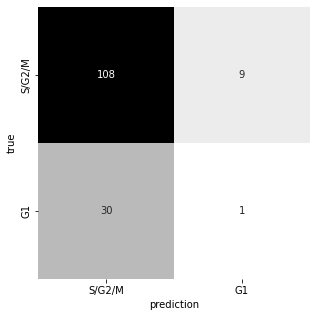

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns 


mat = confusion_matrix(label,df['prediction'])
plt.figure(figsize = (5,5))
sns.heatmap(mat,cmap='binary', square= True, annot=True, fmt='d', xticklabels=['S/G2/M','G1'], yticklabels=['S/G2/M','G1'], cbar= False)
plt.xlabel("prediction")
plt.ylabel("true")
plt.savefig(save_dir+'confusion_matrix.png')
plt.show()